In [1]:
import json
from pprint import pprint
import sys

import fiona
from shapely.geometry import shape, mapping
from shapely.geometry import MultiPolygon as ShapelyMultiPolygon
from shapely.ops import cascaded_union
from django.contrib.gis.geos import GEOSGeometry

from madmex.models import Region, Country

In [2]:
with fiona.open('/shared_volume/shapefile_mexico_conabio/dest_2015gw.shp',
                    encoding='utf-8') as src:
    fc = list(src)

In [9]:
[feat['geometry']['type'] for feat in fc]

['Polygon',
 'MultiPolygon',
 'MultiPolygon',
 'MultiPolygon',
 'Polygon',
 'MultiPolygon',
 'MultiPolygon',
 'Polygon',
 'Polygon',
 'Polygon',
 'Polygon',
 'MultiPolygon',
 'Polygon',
 'MultiPolygon',
 'Polygon',
 'MultiPolygon',
 'Polygon',
 'MultiPolygon',
 'Polygon',
 'MultiPolygon',
 'Polygon',
 'Polygon',
 'MultiPolygon',
 'Polygon',
 'MultiPolygon',
 'MultiPolygon',
 'MultiPolygon',
 'MultiPolygon',
 'Polygon',
 'MultiPolygon',
 'MultiPolygon',
 'Polygon']

In [4]:
shape_list = [shape(feat['geometry']) for feat in fc]

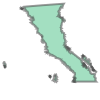

In [6]:
shape_list[1]

In [ ]:
mex_shape = cascaded_union(shape_list)

In [ ]:
GEOSGeometry(mex_shape.wkt, 4326)

In [ ]:
mex, _ = Country.objects.get_or_create(the_geom=GEOSGeometry(mex_shape.wkt, 4326),
                                       name='MEX')

In [ ]:
# Ingest states
for feat in fc:
    name = feat['properties']['NOM_ENT']
    geom = ShapelyMultiPolygon([shape(feat['geometry'])])
    geom = GEOSGeometry(geom.wkt, 4326)
    _ = Region.objects.get_or_create(name=name,
                                     the_geom=geom,
                                     country=mex)
    print(name)